In [1]:
import requests
import numpy as np
import pandas as pd
import json
import csv
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import seaborn as sns

import geopandas
import ellipsis as el
import h3pandas

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Documentation
### API: https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/all/
### Site: https://afdc.energy.gov/fuels/electricity_locations.html#/find/nearest?fuel=ELEC

### NOTES
- charger locations include US and Canada
- have network information
- have hexagons for north america
- have hexagons for US states (no Canada...)
- consider coverage by predominant network


In [2]:
key = 'qSGubKAsQVUiYjN3BNcWJvfMWw7xXskibWDOH86x'
# url = f'https://developer.nrel.gov/api/alt-fuel-stations/v1.json?api_key={key}'
url = f'https://developer.nrel.gov/api/alt-fuel-stations/v1.json?api_key={key}'

In [3]:
body = {
    "status": 'all',
    "access": "public",
    "fuel_type": "ELEC",
    "owner_type":"all",
    "ev_charging_level": "dc_fast",
    "country":"all",
    "limit": "all",
    #"state": "VT"
    #"zip":"05402"
}

response = requests.get(url,params=body)
print(response.status_code)

200


In [4]:
data = json.loads(response.content)
raw = pd.DataFrame(data["fuel_stations"])
summary = pd.DataFrame(data["station_counts"])

In [5]:
raw.columns

Index(['access_code', 'access_days_time', 'access_detail_code',
       'cards_accepted', 'date_last_confirmed', 'expected_date',
       'fuel_type_code', 'groups_with_access_code', 'id', 'open_date',
       'owner_type_code', 'status_code', 'restricted_access',
       'maximum_vehicle_class', 'station_name', 'station_phone', 'updated_at',
       'facility_type', 'geocode_status', 'latitude', 'longitude', 'city',
       'intersection_directions', 'plus4', 'state', 'street_address', 'zip',
       'country', 'bd_blends', 'cng_dispenser_num', 'cng_fill_type_code',
       'cng_psi', 'cng_renewable_source', 'cng_total_compression',
       'cng_total_storage', 'cng_vehicle_class', 'cng_has_rng',
       'e85_blender_pump', 'e85_other_ethanol_blends', 'ev_connector_types',
       'ev_dc_fast_num', 'ev_level1_evse_num', 'ev_level2_evse_num',
       'ev_network', 'ev_network_web', 'ev_other_evse', 'ev_pricing',
       'ev_renewable_source', 'hy_is_retail', 'hy_pressures', 'hy_standards',
       '

In [6]:
df_ = raw[['access_code', 'access_days_time', 'access_detail_code',
       'cards_accepted', 'id', 'status_code', 'restricted_access','fuel_type_code','open_date',
       'maximum_vehicle_class', 'station_name', 'station_phone', 'updated_at','owner_type_code',
       'facility_type', 'geocode_status', 'latitude', 'longitude', 'city',
       'intersection_directions', 'plus4', 'state', 'street_address', 'zip','country', 
# 'bd_blends', 'cng_dispenser_num', 'cng_fill_type_code','cng_psi', 'cng_renewable_source', 'cng_total_compression','cng_total_storage', 'cng_vehicle_class', 'cng_has_rng','e85_blender_pump', 'e85_other_ethanol_blends', 
       'ev_connector_types','ev_dc_fast_num', 'ev_level1_evse_num', 'ev_level2_evse_num', 
       'ev_network', 'ev_network_web', 'ev_other_evse', 'ev_pricing','ev_renewable_source', 
# 'hy_is_retail', 'hy_pressures', 'hy_standards','hy_status_link', 'lng_renewable_source', 'lng_vehicle_class','lng_has_rng', 'lpg_primary', 
# 'lpg_nozzle_types', 'ng_fill_type_code','ng_psi', 'ng_vehicle_class', 'rd_blends', 'rd_blends_fr','rd_blended_with_biodiesel', 'rd_max_biodiesel_level', 'nps_unit_name',
# 'access_days_time_fr', 'intersection_directions_fr', 'bd_blends_fr','groups_with_access_code_fr', 'ev_pricing_fr', 
        'ev_network_ids']]

In [7]:
df_.shape

(10235, 35)

In [8]:
np.unique(raw.status_code)

array(['E', 'P', 'T'], dtype=object)

In [9]:
for i in raw.columns:
    try:
        print(i, np.unique(raw[[i]]))
    except:
        pass

access_code ['public']
fuel_type_code ['ELEC']
groups_with_access_code ['PLANNED - not yet accessible (Public - Call ahead)'
 'PLANNED - not yet accessible (Public - Card key at all times)'
 'PLANNED - not yet accessible (Public - Credit card at all times)'
 'PLANNED - not yet accessible (Public)' 'Public' 'Public - Call ahead'
 'Public - Card key at all times' 'Public - Credit card at all times'
 'TEMPORARILY UNAVAILABLE (Public - Call ahead)'
 'TEMPORARILY UNAVAILABLE (Public - Credit card at all times)'
 'TEMPORARILY UNAVAILABLE (Public)']
id [ 38309  38521  38522 ... 302753 302758 302759]
status_code ['E' 'P' 'T']
station_name ['#1 Cochran Nissan' '(Formerly) Fresh & Easy'
 '1 Flatiron Crossing (US-ME8-73R-1A)' ... 'efficiencyPEI – O’Leary Tim’s'
 'efficiencyPEI – Souris Irving' 'Édifice 019']
updated_at ['2021-03-11T23:22:17Z' '2021-03-30T21:09:19Z' '2021-03-31T19:22:49Z' ...
 '2023-07-18T02:15:10Z' '2023-07-18T02:15:11Z' '2023-07-18T13:03:44Z']
geocode_status ['200-5' '200-6' '20

In [10]:
df_ = raw[['id','open_date','status_code','latitude','longitude' ,'state','zip','country','ev_dc_fast_num','ev_network','groups_with_access_code']]

In [11]:
df_['credit'] = pd.np.where(df_.groups_with_access_code.str.contains("Credit"),1,0)  

In [12]:
df_.head()

,id,open_date,status_code,latitude,longitude,state,zip,country,ev_dc_fast_num,ev_network,groups_with_access_code,credit
0,38309,2011-03-15,E,34.852437,-82.399901,SC,29601,US,1,Non-Networked,Public,0
1,38521,2010-11-15,E,34.010528,-118.489800,CA,90401,US,2,Non-Networked,Public,0
2,38522,2010-10-19,E,39.843886,-104.771138,CO,80022,US,1,Non-Networked,Public,0
3,39114,2011-01-15,E,30.206145,-97.759109,TX,78745,US,1,Non-Networked,Public - Call ahead,0
4,39711,2011-03-15,E,30.374542,-97.731445,TX,78758,US,1,Non-Networked,Public - Call ahead,0


### MAPPING + HEX MAPPING
##### https://python.plainenglish.io/creating-beautiful-hexagon-maps-with-python-25c9291eeeda
##### https://stackoverflow.com/questions/63516948/how-to-convert-shapefile-geojson-to-hexagons-using-uber-h3-in-python

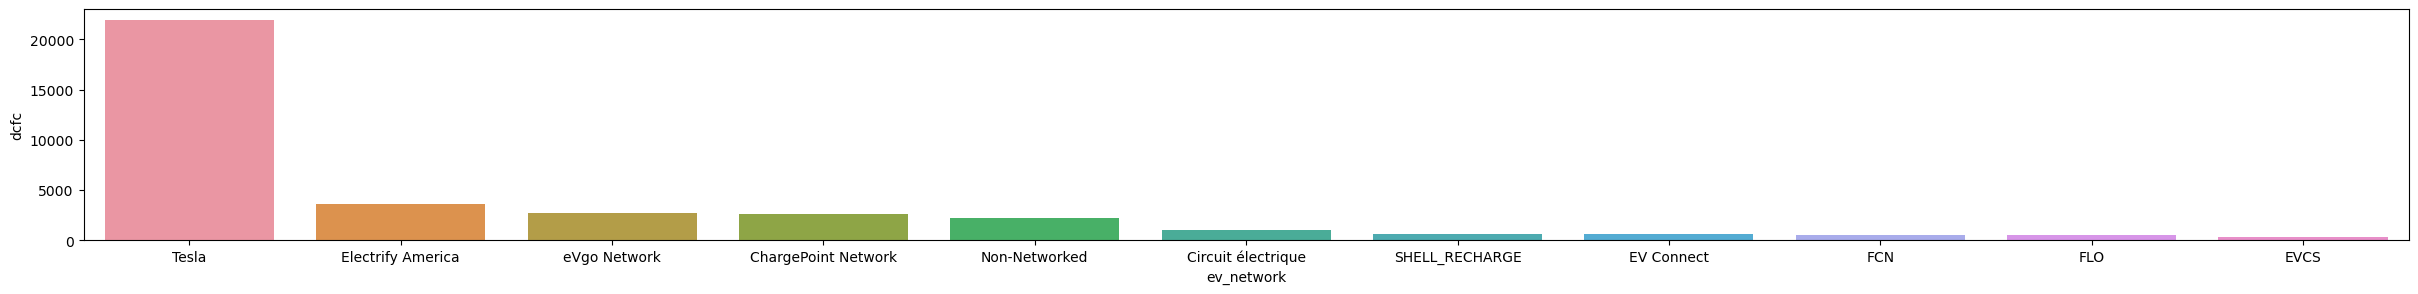

In [167]:
data = df_.groupby('ev_network',as_index=False).agg(dcfc = ('ev_dc_fast_num','sum')).sort_values('dcfc',ascending=False).reset_index(drop=True)
data = data[data.dcfc > 300]

plt.figure(figsize=(30,3))
sns.barplot(data=data,x='ev_network',y='dcfc');

In [102]:
state_groups = df_.groupby(['ev_network','state','country'],as_index=False).agg({'ev_dc_fast_num':'sum'}).sort_values('ev_dc_fast_num',ascending=False).reset_index(drop=True)
state_totals = df_.groupby(['state','country'],as_index=False).agg(total_dc=('ev_dc_fast_num', 'sum')).reset_index(drop=True)
state_dc = state_groups.merge(state_totals).reset_index(drop=True)
state_dc['dc_pct'] = state_dc.ev_dc_fast_num/state_dc.total_dc

<AxesSubplot:>

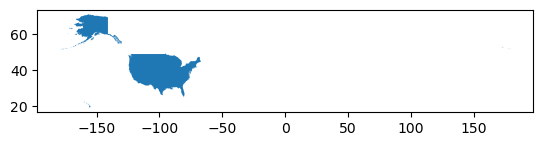

In [16]:
import geopandas
import h3pandas
import ellipsis as el

pathId = '1a24a1ee-7f39-4d21-b149-88df5a3b633a'
timestampId = '45c47c8a-035e-429a-9ace-2dff1956e8d9'

sh_countries = el.path.vector.timestamp.listFeatures(pathId, timestampId)['result']

sh_usa = sh_countries[sh_countries['NAME'] == 'United States']
sh_usa.plot()

In [17]:
sh_usa

,geometry,UN,LAT,LON,AREA,FIPS,ISO2,ISO3,NAME,REGION,POP2005,SUBREGION,id,userId
83,"MULTIPOLYGON (((-75.17029 19.93139, -75.22372 ...",840,39.622,-98.606,915896,US,US,USA,United States,19,299846449,21,60dcf3df-3ee8-41d5-a001-6620fb2e382a,9113af2b-943f-4689-b5f4-e575167d5a38


In [18]:
sh_as_crs = sh_usa.to_crs('EPSG:2264')

In [19]:
print(type(sh_as_crs),type(sh_usa))

<class 'geopandas.geodataframe.GeoDataFrame'> <class 'geopandas.geodataframe.GeoDataFrame'>


In [20]:
## https://stackoverflow.com/questions/63516948/how-to-convert-shapefile-geojson-to-hexagons-using-uber-h3-in-python

In [225]:
import geopandas as gpd
import h3pandas

# Prepare data
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gdf.loc[gdf['continent'].eq('North America')]
gdf['gdp_md_per_capita'] = gdf['gdp_md_est'].div(gdf['pop_est'])
# gdf = gdf[gdf.name == 'Canada']
gdf = gdf[gdf['name'].isin(['United States of America','Canada'])]

resolution = 3

# Resample to H3 cells
gdf_h3 = gdf.h3.polyfill_resample(resolution)
gdf_h3 = gdf.h3.polyfill(resolution, explode=True)
gdf_h3 = gdf_h3.set_index('h3_polyfill').h3.h3_to_geo_boundary()

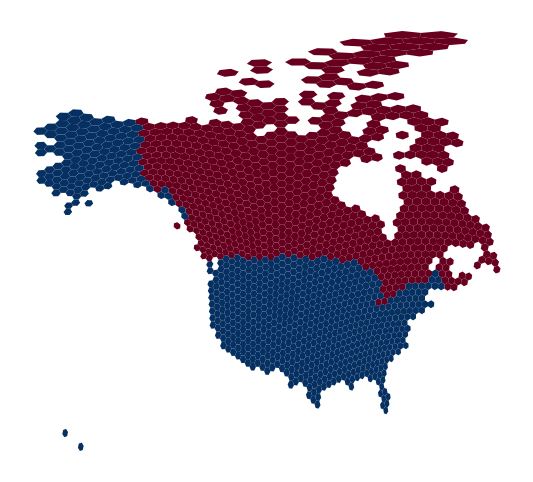

In [226]:
ax = gdf_h3.plot(figsize=(8, 6), column='gdp_md_per_capita', cmap='RdBu')
ax.axis('off');

In [33]:
dc_gdf = geopandas.GeoDataFrame(
    df_, geometry=geopandas.points_from_xy(df_.longitude, df_.latitude), crs="EPSG:4326"
)

In [173]:
gdf_h3['count'] = 0
dc_gdf['h3_polyfill']

for i in range(dc_gdf.shape[0]):
    charger = dc_gdf['geometry'].values[i]
    update_bools = gdf_h3.intersects(charger)
    dc_gdf.loc[]
    gdf_h3.loc[update_bools, 'count'] = gdf_h3.loc[update_bools, 'count'] + 1

KeyError: 'count'

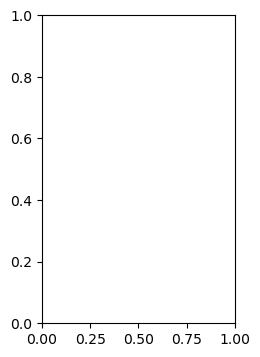

In [168]:
import matplotlib
ax = gdf_h3.plot(figsize=(4, 4), column='count',cmap='ocean_r',legend=True,
                norm=matplotlib.colors.LogNorm(vmin=1, vmax=300))
# ax.axis('off');

## STATES, PROVINCES, TERRITORIES
##### US only (not used): https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/us_states_hexgrid.geojson.json
##### US + Canada: https://twitter.com/mapsOverlord/status/1415348994780270596
##### Pop. US: https://gist.githubusercontent.com/tnightingale/4696122/raw/20d0f6813f5a0fd1d7b4877fd51eebb62f4b0dba/census-profile.csv
##### Pop. Canada:https://gist.githubusercontent.com/bradoyler/0fd473541083cfa9ea6b5da57b08461c/raw/fa5f59ff1ce7ad9ff792e223b9ac05c564b7c0fe/us-state-populations.csv

In [39]:
# Load file
url = "https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/us_states_hexgrid.geojson.json"
us_geoData = gpd.read_file(url)

In [72]:
na_geoData = gpd.read_file('data/usca_states_provinces/usca_states_provinces.shp')
na_geoData['state'] = na_geoData['State_Abbr']
na_geoData['country'] = na_geoData['Country'].apply(lambda x: 'CA' if x== 'Canada' else 'US')
na_geoData['centroid'] = na_geoData['geometry'].apply(lambda x: x.centroid)

In [73]:
na_geoData.head(2)

,State,State_Abbr,Country,geometry,state,country,centroid
0,Manitoba,MB,Canada,"POLYGON ((8.99962 8.60023, 8.99962 9.70023, 9....",MB,CA,POINT (9.99962 9.15023)
1,Nunavut,NU,Canada,"POLYGON ((5.99962 10.30023, 5.99962 11.40023, ...",NU,CA,POINT (6.99962 10.85023)


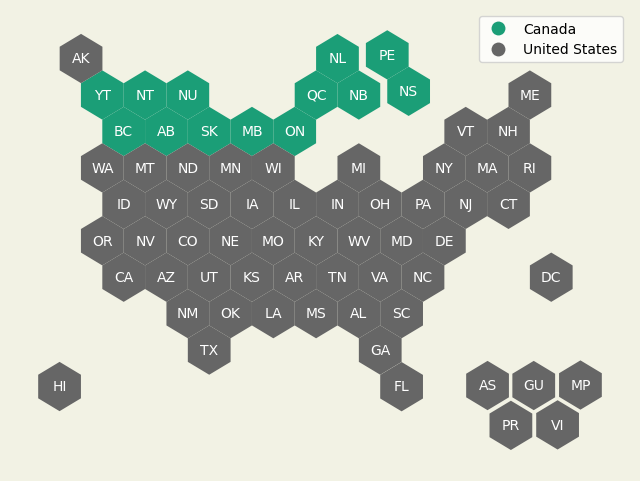

In [321]:
fig, ax = plt.subplots(1, 1,figsize=(8, 6))

na_geoData.plot(
    figsize=(8, 8),
    column="Country",
    ax=ax,
    legend=True,
    # cax=cax,
    cmap = "Dark2",
)

fig.set(facecolor = "#f2f2e4")
ax.set(facecolor = "#f2f2e4")

for idx, row in na_geoData.iterrows():
    ax.annotate(text=row['state'], xy=row['centroid'].coords[0], horizontalalignment='center', va='center',color='white')

ax.axis('off');

In [ ]:
# state_groups - grouped: network, state, country
# state_totals - grouped: state, country
# state_dc - state_groups.merge(state_totals), includes percentage share

In [198]:
# Popuation by State, Province, Territory
ca_pop = pd.read_csv('https://gist.githubusercontent.com/tnightingale/4696122/raw/20d0f6813f5a0fd1d7b4877fd51eebb62f4b0dba/census-profile.csv',
                    usecols = ['Prov_Name','Total'])
ca_pop.columns = ['State','population']

us_pop = pd.read_csv('https://gist.githubusercontent.com/bradoyler/0fd473541083cfa9ea6b5da57b08461c/raw/fa5f59ff1ce7ad9ff792e223b9ac05c564b7c0fe/us-state-populations.csv',
        usecols=['state','pop_2014'],header=0)
us_pop.columns = ['State', 'population']

pop = pd.concat([ca_pop,us_pop])

In [200]:
state_dc.head()

,ev_network,state,country,ev_dc_fast_num,total_dc,dc_pct
0,Tesla,CA,US,5732,9430,0.607847
1,eVgo Network,CA,US,1150,9430,0.121951
2,Electrify America,CA,US,992,9430,0.105196
3,ChargePoint Network,CA,US,572,9430,0.060657
4,Non-Networked,CA,US,280,9430,0.029692


In [227]:
np.unique(state_dc.ev_network)

array(['7CHARGE', 'AMPUP', 'AddÉnergie Technologies', 'BCHYDRO',
       'Blink Network', 'CHARGELAB', 'CHARGEUP', 'CIRCLE_K',
       'COUCHE_TARD', 'ChargePoint Network', 'Circuit électrique',
       'EV Connect', 'EVCS', 'EVGATEWAY', 'EVRANGE', 'Electrify America',
       'Electrify Canada', 'FCN', 'FLO', 'FPLEV', 'GRAVITI_ENERGY', 'IVY',
       'LIVINGSTON', 'NOODOE', 'Non-Networked', 'OpConnect', 'PETROCAN',
       'POWERFLEX', 'RED_E', 'RIVIAN_ADVENTURE', 'SHELL_RECHARGE',
       'SWTCH', 'Tesla', 'Tesla Destination', 'UNIVERSAL', 'Volta',
       'ZEFNET', 'eCharge Network', 'eVgo Network'], dtype=object)

In [217]:
max_network = state_dc.sort_values('ev_dc_fast_num', ascending=False).drop_duplicates(['state','country']).reset_index(drop=True)
max_network_not_tesla = state_dc[state_dc.ev_network != 'Tesla'].sort_values('ev_dc_fast_num', ascending=False).drop_duplicates(['state','country']).reset_index(drop=True)
all_network_geo = na_geoData.merge(state_dc).merge(pop,how='left')

all_network_geo['dcfc_per_capita'] = all_network_geo.ev_dc_fast_num/all_network_geo.population
all_network_geo['dcfc_per_k'] = all_network_geo.ev_dc_fast_num/all_network_geo.population*1000
all_network_geo['dcfc_per_10k'] = all_network_geo.ev_dc_fast_num/all_network_geo.population*10000
all_network_geo['dcfc_per_mm'] = all_network_geo.ev_dc_fast_num/all_network_geo.population*1000000

In [204]:
all_network_geo.head(2)

,State,State_Abbr,Country,geometry,state,country,centroid,ev_network,ev_dc_fast_num,total_dc,dc_pct,population,dcfc_per_capita
0,Manitoba,MB,Canada,"POLYGON ((8.99962 8.60023, 8.99962 9.70023, 9....",MB,CA,POINT (9.99962 9.15023),Tesla,32,108,0.296296,1208268.0,0.000026
1,Manitoba,MB,Canada,"POLYGON ((8.99962 8.60023, 8.99962 9.70023, 9....",MB,CA,POINT (9.99962 9.15023),SHELL_RECHARGE,26,108,0.240741,1208268.0,0.000022


In [ ]:
# laura's todo:
# assign colors to chargers so they are fixed
# make browns golden yellow
# add state/province populations
# consider reciprocity - FLO + CP

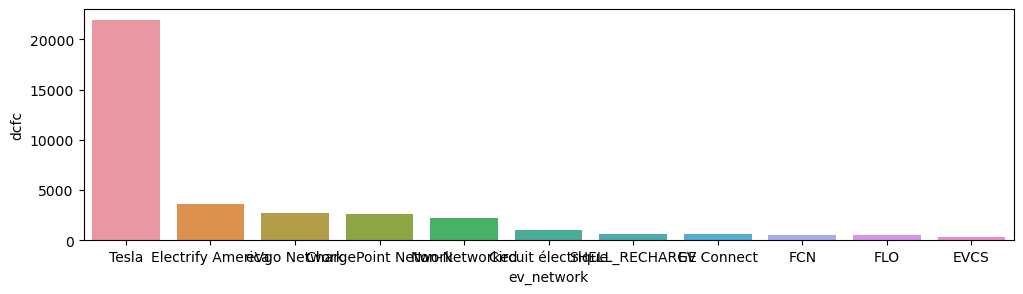

In [330]:
data_network = df_.groupby('ev_network',as_index=False).agg(dcfc = ('ev_dc_fast_num','sum')).sort_values('dcfc',ascending=False).reset_index(drop=True)
data = data_network[data_network.dcfc > 300]

plt.figure(figsize=(12,3))
plt.xlabel('none')
sns.barplot(data=data,x='ev_network',y='dcfc');

In [247]:
networkList = ['Electrify America',
               'eVgo Network',
               'ChargePoint Network', 
               'Circuit électrique', 
               'SHELL_RECHARGE',
               'EV Connect',
               'FCN',
               'FLO',
               'eCharge Network']

networkList = data_network.ev_network.values

In [248]:
networkList

array(['Tesla', 'Electrify America', 'eVgo Network',
       'ChargePoint Network', 'Non-Networked', 'Circuit électrique',
       'SHELL_RECHARGE', 'EV Connect', 'FCN', 'FLO', 'EVCS',
       'RIVIAN_ADVENTURE', 'IVY', 'BCHYDRO', 'Volta', 'Electrify Canada',
       'PETROCAN', 'EVGATEWAY', 'Blink Network', 'FPLEV',
       'GRAVITI_ENERGY', 'CIRCLE_K', '7CHARGE', 'COUCHE_TARD', 'ZEFNET',
       'EVRANGE', 'RED_E', 'eCharge Network', 'CHARGELAB',
       'Tesla Destination', 'OpConnect', 'POWERFLEX', 'SWTCH', 'NOODOE',
       'UNIVERSAL', 'LIVINGSTON', 'AMPUP', 'CHARGEUP',
       'AddÉnergie Technologies'], dtype=object)

## NETWORK ROAMING:
- Tesla
- FLO, ChargePoint, eCharge Network, Shell Recharge, Circuit électrique 
- Electrify America - works to plug in based on car type
- EVgo
- EV Connect
- FCN

### DCFC AS PERCENTAGE OF CHARGERS IN STATE/PROVINCE

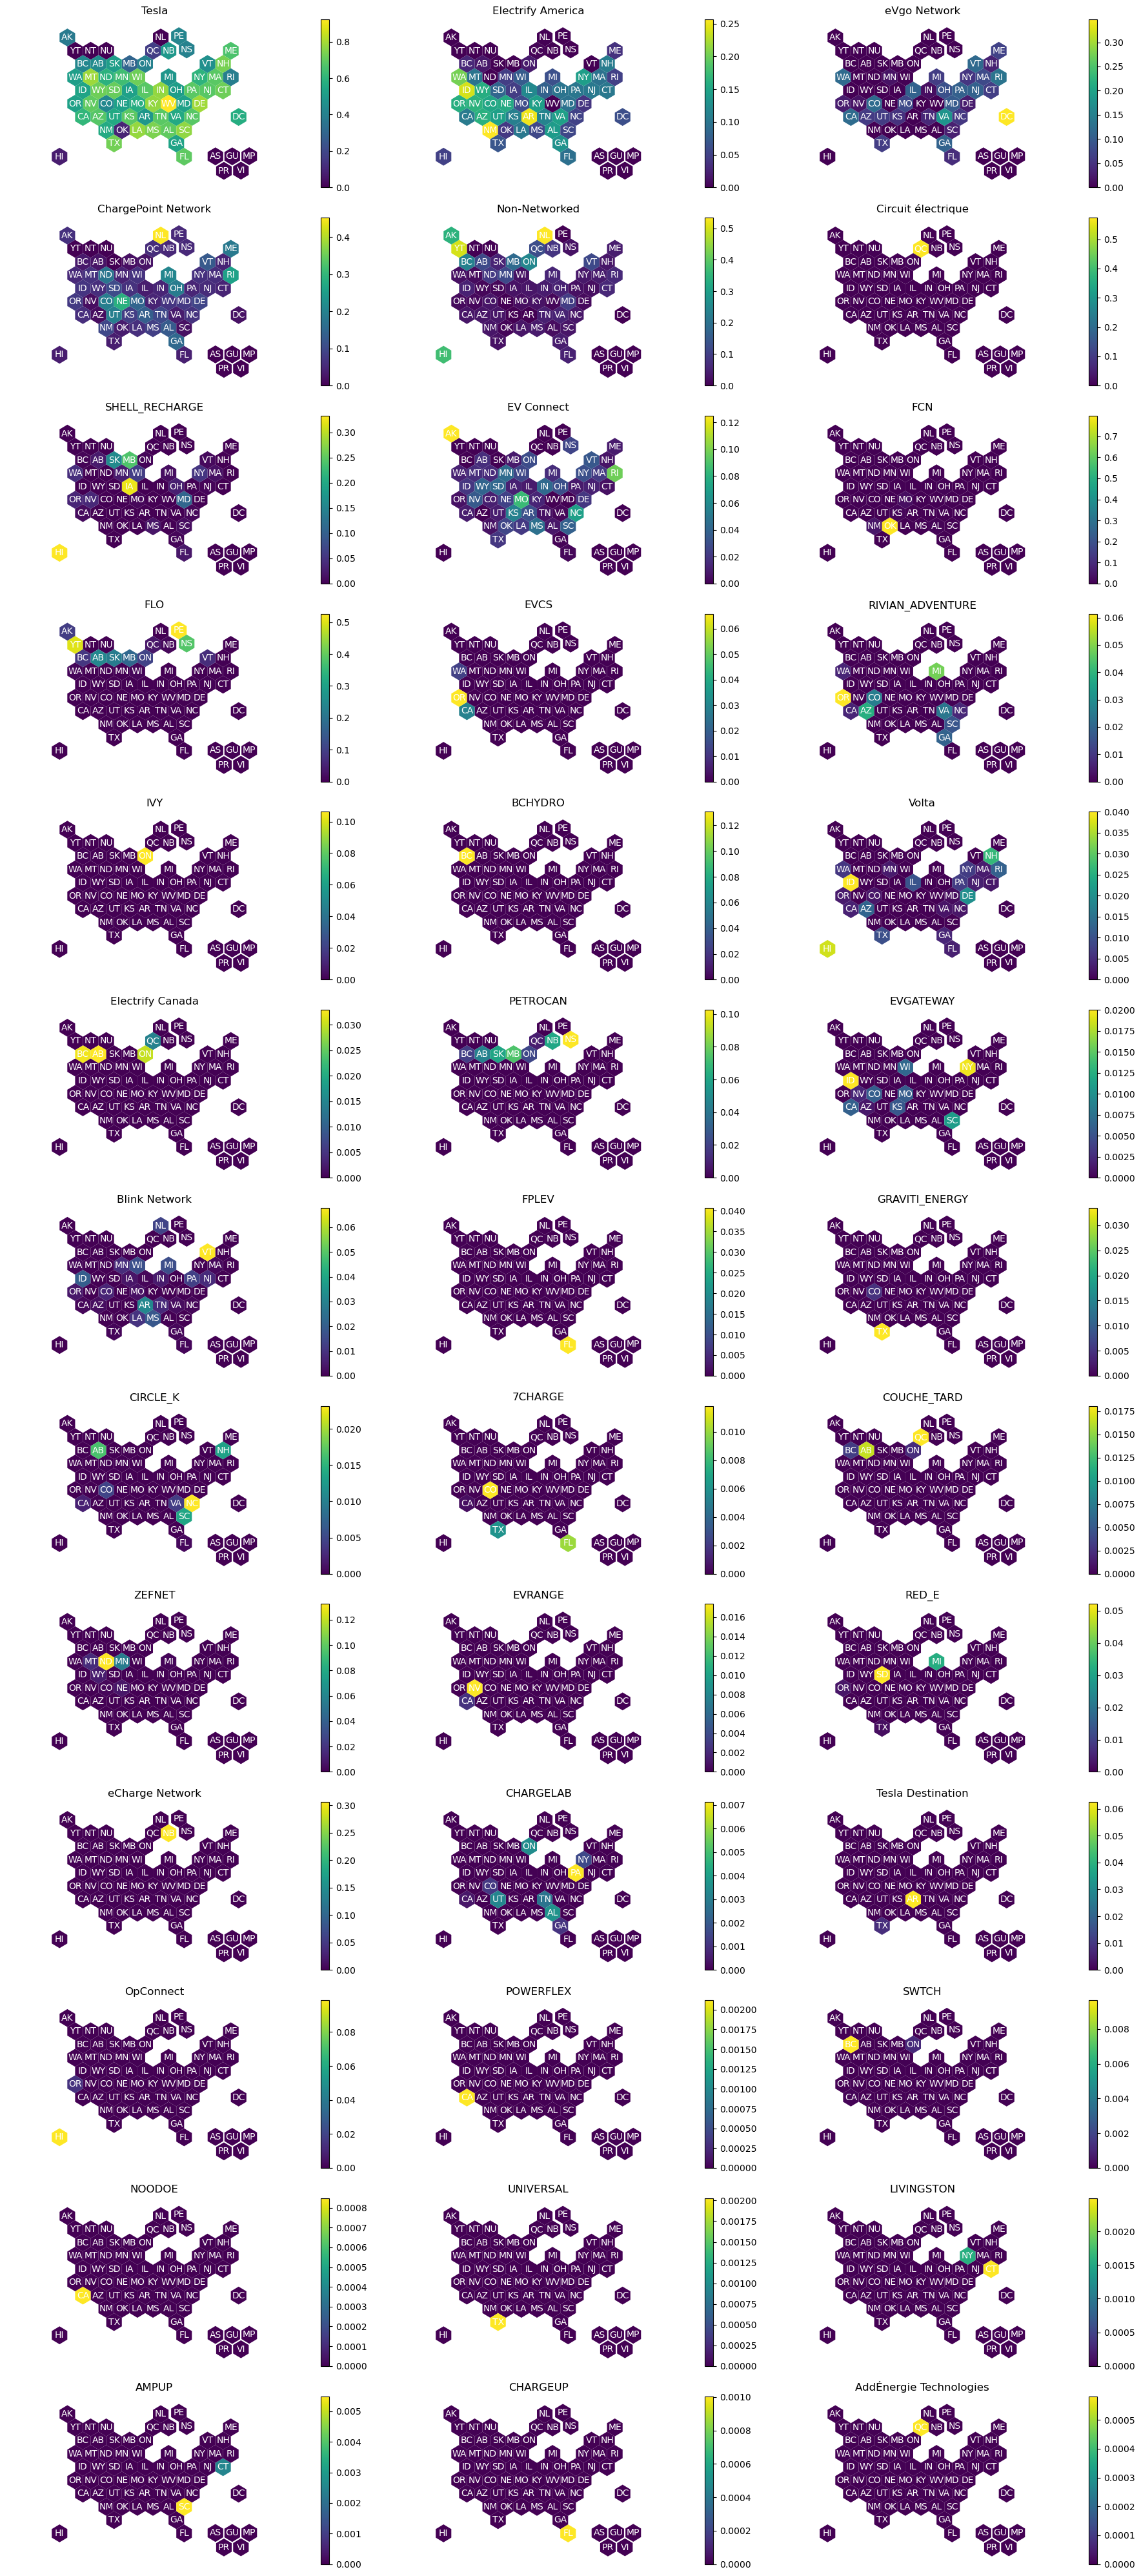

In [356]:
plt.figure(figsize=(18, 40))

# Iterate through continents

for i, network in enumerate(networkList):
    # filter network
    sub = all_network_geo[all_network_geo.ev_network == network]
    sub = sub[['State_Abbr','ev_dc_fast_num','dc_pct','ev_network']]
    data = na_geoData.merge(sub,how='left')
    data = data.fillna(0) # remove 0
    
    
    # create subplot axes in a 3x3 grid
    ax = plt.subplot(int(round(len(networkList)/3,0)),3, i + 1) # nrows, ncols, axes position
    # plot the continent on these axes
    data.plot(ax=ax,column='dc_pct',cmap='viridis',legend=True)
    # set the title
    ax.set_title(network)
    # set the aspect
    # adjustable datalim ensure that the plots have the same axes size
    ax.set_aspect('equal', adjustable='datalim')
    # fig.set(facecolor = "#f2f2e4")
    ax.axis('off')
    
    for idx, row in data.iterrows():
        plt.annotate(text=row['state'], xy=row['centroid'].coords[0], horizontalalignment='center', va='center',color='white')

plt.tight_layout()
plt.show()

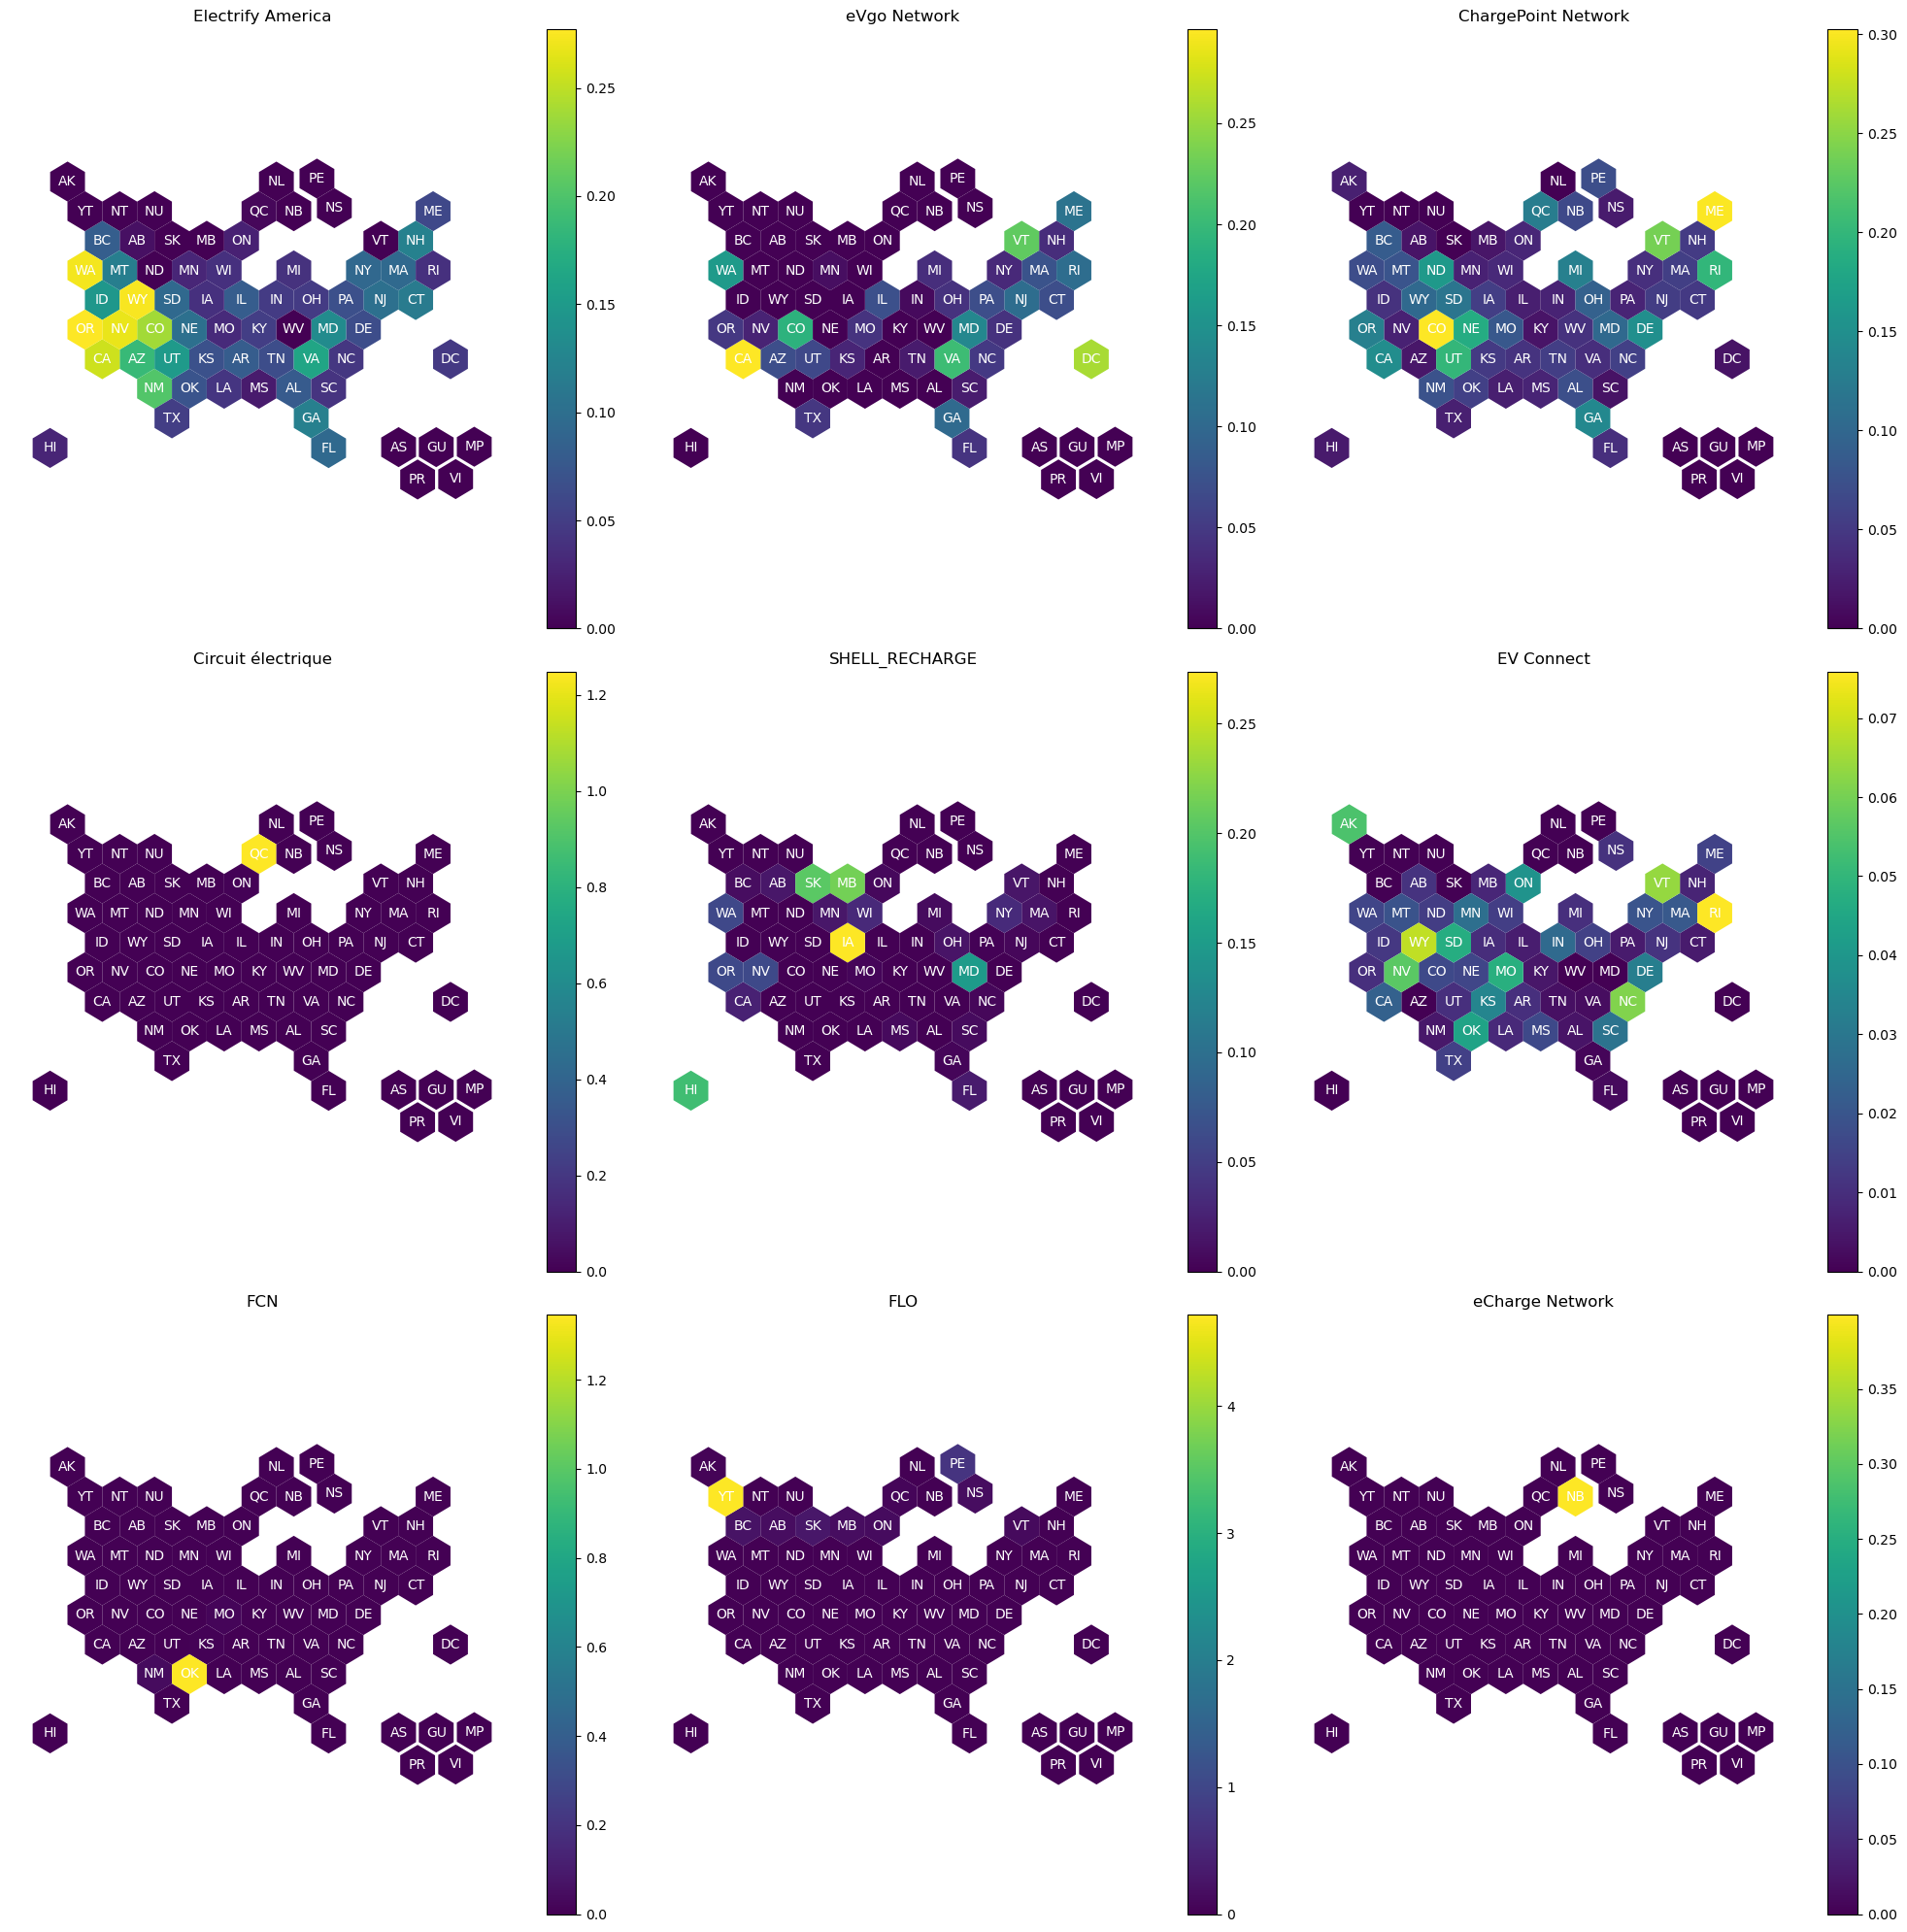

In [219]:
plt.figure(figsize=(20, 20))

# Iterate through continents

for i, network in enumerate(networkList):
    # filter network
    sub = all_network_geo[all_network_geo.ev_network == network]
    sub = sub[['State_Abbr','ev_dc_fast_num','dc_pct','ev_network','dcfc_per_10k']]
    data = na_geoData.merge(sub,how='left')
    data = data.fillna(0) # remove 0
    
    
    # create subplot axes in a 3x3 grid
    ax = plt.subplot(3, 3, i + 1) # nrows, ncols, axes position
    # plot the continent on these axes
    data.plot(ax=ax,column='dcfc_per_10k',cmap='viridis',legend=True)
    # set the title
    ax.set_title(network)
    # set the aspect
    # adjustable datalim ensure that the plots have the same axes size
    ax.set_aspect('equal', adjustable='datalim')
    ax.axis('off')
    
    for idx, row in data.iterrows():
        plt.annotate(text=row['state'], xy=row['centroid'].coords[0], horizontalalignment='center', va='center',color='white')

plt.tight_layout()
plt.show()

# TESLA

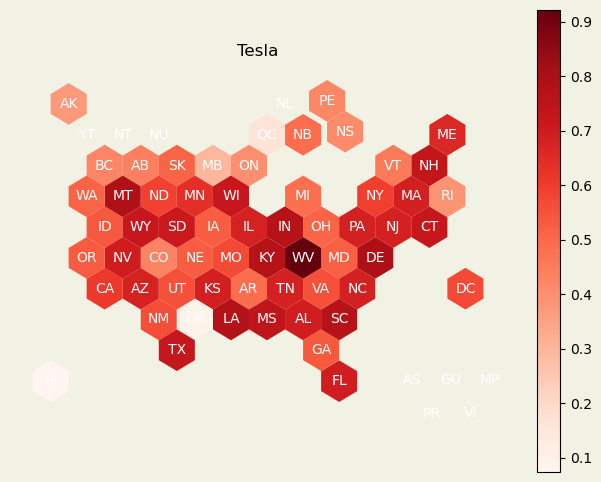

In [334]:
network_df = state_dc[state_dc.ev_network=='Tesla']
select_network_geo = na_geoData.merge(network_df)
network = 'Tesla'



fig, ax = plt.subplots(1, 1,figsize=(8, 6))

select_network_geo.plot(
    figsize=(8, 8),
    column="dc_pct",
    ax=ax,
    legend=True,
    # cax=cax,
    cmap = "Reds",
)
ax.set_title(f'{network}')
fig.set(facecolor = "#f2f2e4")
ax.set(facecolor = "#f2f2e4")

for idx, row in na_geoData.iterrows():
    ax.annotate(text=row['state'], xy=row['centroid'].coords[0], horizontalalignment='center', va='center',color='white')

ax.axis('off');

###
# ax = select_network_geo.plot(figsize=(10, 8), column='dc_pct',cmap='Oranges',legend=True)


# ax.axis('off')
# ax.set_title(f'{network}')



# for idx, row in select_network_geo.iterrows():
#     plt.annotate(text=row['state'], xy=row['centroid'].coords[0], horizontalalignment='center', va='center',color='white')

# Removing Tesla

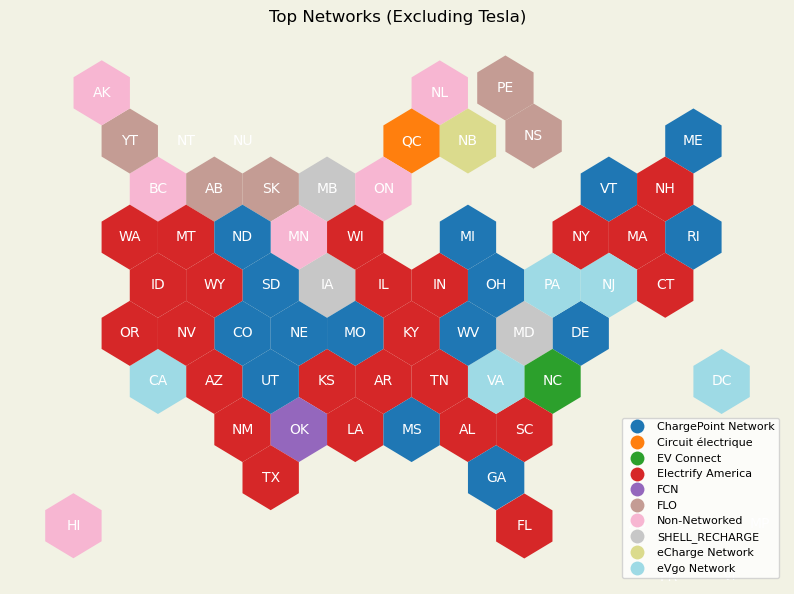

In [355]:
max_network_geo = na_geoData.merge(max_network_not_tesla)


fig, ax = plt.subplots(1, 1,figsize=(10, 10))

max_network_geo.plot(
    # figsize=(10, 8),
    column="ev_network",
    ax=ax,
    legend=True,
    legend_kwds={'loc': 'lower right','fontsize':8},
    cmap = "tab20",
)
ax.set_title('Top Networks (Excluding Tesla)')
fig.set(facecolor = "#f2f2e4")
ax.set(facecolor = "#f2f2e4")

for idx, row in na_geoData.iterrows():
    ax.annotate(text=row['state'], xy=row['centroid'].coords[0], horizontalalignment='center', va='center',color='white')

ax.axis('off');

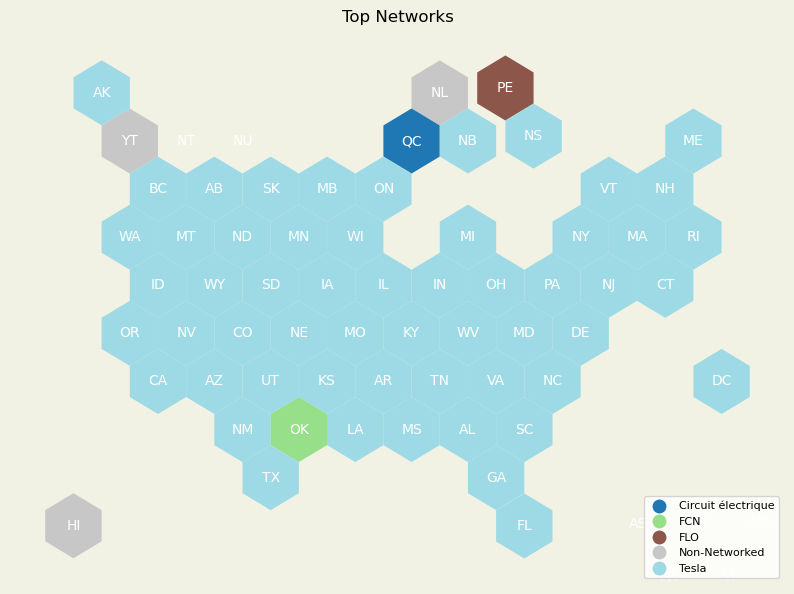

In [354]:
max_network_geo = na_geoData.merge(max_network)

fig, ax = plt.subplots(1, 1,figsize=(10, 10))

max_network_geo.plot(
    column="ev_network",
    ax=ax,
    legend=True,
    legend_kwds={'loc': 'lower right','fontsize':8},
    cmap = "tab20",
)
ax.set_title('Top Networks')
fig.set(facecolor = "#f2f2e4")
ax.set(facecolor = "#f2f2e4")

for idx, row in na_geoData.iterrows():
    ax.annotate(text=row['state'], xy=row['centroid'].coords[0], horizontalalignment='center', va='center',color='white')

ax.axis('off');

#

# ax = max_network_geo.plot(figsize=(8, 8), column='ev_network',cmap='tab20',legend=True,legend_kwds={'loc': 'lower right'})
# ax.axis('off')
# for idx, row in max_network_geo.iterrows():
#     plt.annotate(text=row['state'], xy=row['centroid'].coords[0], horizontalalignment='center', va='center',color='white')

In [70]:
max_network_not_tesla

,ev_network,state,country,ev_dc_fast_num,total_dc,dc_pct
0,eVgo Network,CA,US,1150,9430,0.121951
1,Circuit électrique,QC,CA,986,1717,0.574257
2,FCN,OK,US,522,654,0.798165
3,Non-Networked,ON,CA,428,1733,0.246971
4,Non-Networked,BC,CA,289,1241,0.232877
...,...,...,...,...,...,...
57,Non-Networked,AK,US,11,32,0.343750
58,ChargePoint Network,SD,US,10,96,0.104167
59,FLO,PE,CA,10,19,0.526316
60,ChargePoint Network,MS,US,9,108,0.083333


In [ ]:
state_dc.groupby('state','country').agg(total_dc=('ev_dc_fast_num', 'sum'))

In [40]:
us_geoData['state'] = us_geoData['iso3166_2']
us_geoData = us_geoData.merge(state_totals)

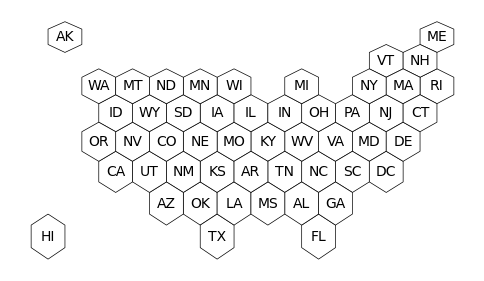

In [41]:
# add a "centroid" column with the centroid position of each county
us_geoData['centroid'] = us_geoData['geometry'].apply(lambda x: x.centroid)

# redraw the empty hexbin map:
us_geoData.plot(figsize=(6, 6),color="white", edgecolor='black', linewidth=.5);
plt.axis('off');

# for each county, annotate with the county name located at the centroid coordinates 
for idx, row in us_geoData.iterrows():
    plt.annotate(text=row['iso3166_2'], xy=row['centroid'].coords[0], horizontalalignment='center', va='center')

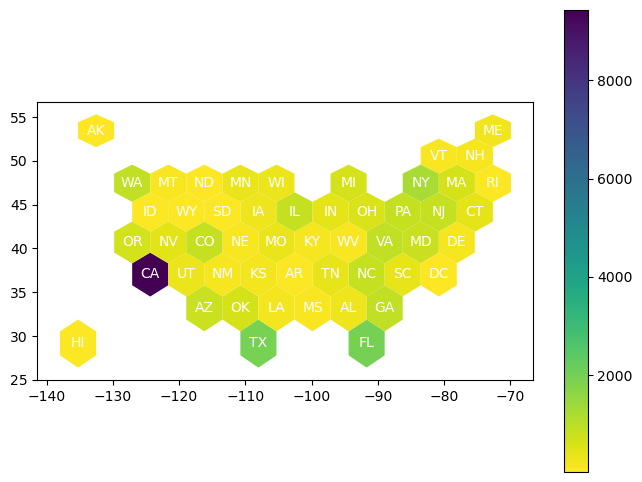

In [247]:
# ax = us_geoData.plot(figsize=(8, 6), column='count',cmap='viridis',legend=True)

# redraw the empty hexbin map:
ax = us_geoData.plot(figsize=(8, 6), column='total_dc',cmap='viridis_r',legend=True)

for idx, row in us_geoData.iterrows():
    plt.annotate(text=row['iso3166_2'], xy=row['centroid'].coords[0], horizontalalignment='center', va='center',color='white')

In [ ]:


# Remove useless axis
ax.axis('off');

# Add title, subtitle and author
ax.annotate('Mariage rate in the US', xy=(10,440),  xycoords='axes pixels', horizontalalignment='left', verticalalignment='top', fontsize=14, color='black')
ax.annotate('Yes, people love to get married in Vegas', xy=(10,420),  xycoords='axes pixels', horizontalalignment='left', verticalalignment='top', fontsize=11, color='#808080')
ax.annotate('python-graph-gallery.com', xy=(600,0),  xycoords='axes pixels', horizontalalignment='left', verticalalignment='top', fontsize=8, color='#808080')

# for each county, annotate with the county name located at the centroid coordinates 
for idx, row in geoData.iterrows():
    ax.annotate(
        s=row['iso3166_2'], 
        xy=row['centroid'].coords[0], 
        horizontalalignment='center', 
        va='center',
        color="white"
    )

# Add a color bar
sm = plt.cm.ScalarMappable(cmap='BuPu', norm=plt.Normalize(vmin=2, vmax=13))
fig.colorbar(sm, orientation="horizontal", aspect=50, fraction=0.005, pad=0 );